In [89]:
# MODEL_CKPT_DIR = 'model_params_big_test'
# MODEL_CKPT_DIR = 'res_balanced_accuracy'
# MODEL_CKPT_DIR = 'res_f1'

# MODEL_CKPT_DIR = 'stratified_clusters=2'
MODEL_CKPT_DIR = 'sims=True_stratified_clusters=2'

# MODEL_CKPT_DIR = 'stratified_clusters=9'
MODEL_CKPT_DIR = 'sims=True_stratified_clusters=9'

# LOAD_FIT_ON_DEV = False
LOAD_FIT_ON_DEV = True

# FILTER_POSITIVE_LABEL = True
FILTER_POSITIVE_LABEL = False

FILTER_CATEGORY_ID = 5
# FILTER_CATEGORY_ID = None

In [90]:
import os
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path


if LOAD_FIT_ON_DEV:
    xgb_model_path = Path(MODEL_CKPT_DIR) / 'xgboost_model_fit_on_dev.json'
    scaler_path = Path(MODEL_CKPT_DIR) / 'std_scaler_fit_on_dev.bin'
    
else:
    xgb_model_path = Path(MODEL_CKPT_DIR) / 'xgboost_model.json'
    scaler_path = Path(MODEL_CKPT_DIR) / 'std_scaler.bin'

# Load the scaler and the pre-trained XGBoost model.
scaler = joblib.load(scaler_path)
model = xgb.XGBClassifier()
model.load_model(xgb_model_path)

In [91]:
# Load the data
if LOAD_FIT_ON_DEV:
    MODEL_DATA_FILE = Path(MODEL_CKPT_DIR) / 'data_test.csv'
else:
    MODEL_DATA_FILE = Path(MODEL_CKPT_DIR) / 'data.csv'

# > AVERAGE FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_all_query_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-5_query_pairs.csv'

# > GOOD FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-20_query-23_nonquery-5539_embedded.csv'
DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_pairs.csv'

# > FILES W/INNER RUCLIP AS RANKER
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-30_query-2_nonquery-6_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-20query-23_nonquery-5539_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-20_query-2_nonquery-6_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt_final-embs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/processed/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt_final-embs.csv'

df_all = pd.read_csv(DATA_FILE)
df_model = pd.read_csv(MODEL_DATA_FILE)

# df_all.columns.tolist()

In [92]:
# Compare quantiles for numerical features

# df_model.groupby('label')[[
#     'balance_second',
#     'sales_second',
#     'comments_second',
#     'rating_second'
# ]].describe().T

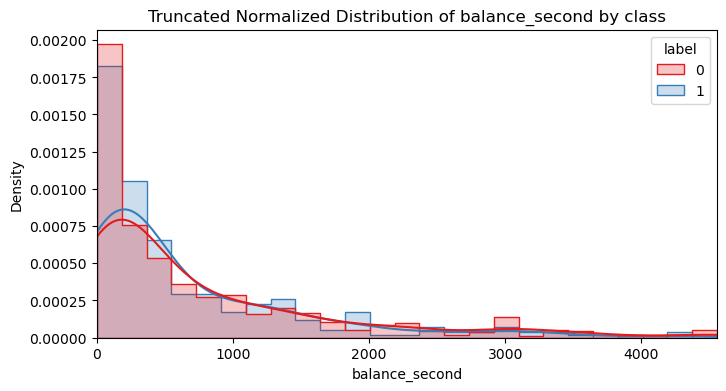

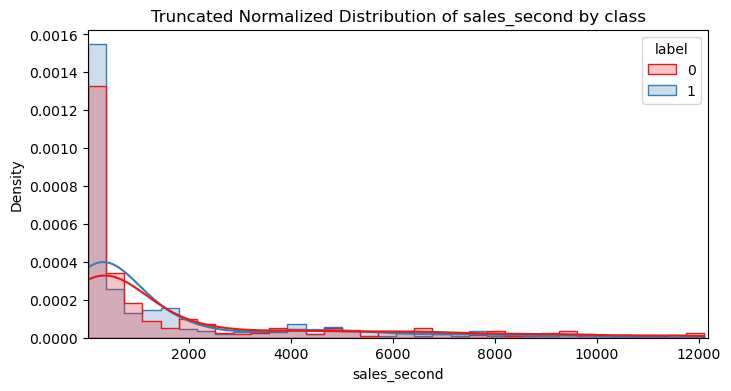

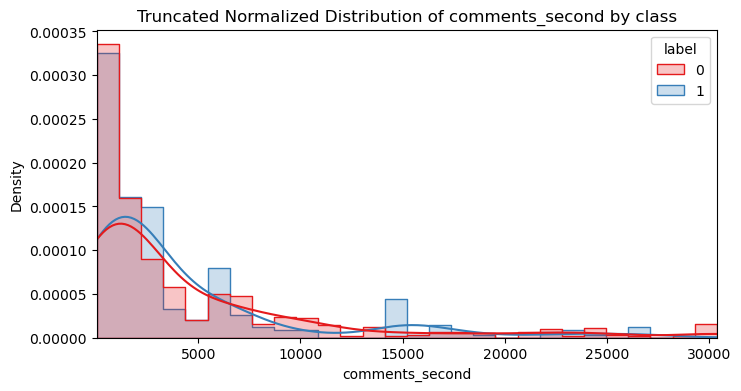

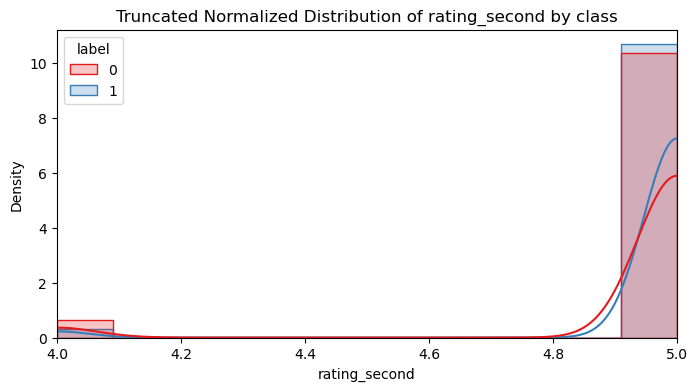

In [93]:
# Visualize truncated normalized histograms of selected columns by 'label'

import matplotlib.pyplot as plt
import seaborn as sns
cols = ['balance_second', 'sales_second', 'comments_second', 'rating_second']
quant = 0.05  # symmetric quantile for truncation

for col in cols:
    lower = df_model[col].quantile(quant)
    upper = df_model[col].quantile(1 - quant)
    plt.figure(figsize=(8, 4))
    subset = df_model[(df_model[col] >= lower) & (df_model[col] <= upper)]
    sns.histplot(
        data=subset,
        x=col,
        hue='label',
        kde=True,
        palette='Set1',
        element="step",
        stat="density",       # normalize counts to density
        common_norm=False     # normalize independently for each hue level
    )
    plt.title(f'Truncated Normalized Distribution of {col} by class')
    plt.xlabel(col)
    plt.xlim(lower, upper)
    plt.ylabel("Density")
    plt.show()

In [94]:
# Filter model data by regex

pd.set_option('display.max_colwidth', None)

keywords = r'карта'
kw_mask = df_model.name_first.str.contains(keywords, case=False, regex=True)

df_model_domain = df_model[
    kw_mask

    # & (df_model.label == 1)
    # & (df_model.label == 0)
]

# for idx, row in df_model_domain.iterrows():
#     print(row.name_first)
#     print(row.sku_first)

#     print(row.name_second)
#     print(row.sku_second)
#     print('-' * 50)
#     print()

# pd.reset_option('display.max_colwidth')

# Run inference

In [95]:
# Choose the dataset to use for inference.

# df_chosen_all = df_all
df_chosen_all = df_model
# df_chosen_all = df_model_domain

In [96]:
N_SKU = 23

df_chosen_all = df_chosen_all.drop(
    df_chosen_all[df_chosen_all['sku_first'] == df_chosen_all['sku_second']].index
)

# First, filter by category if needed, then sample SKU.
if FILTER_CATEGORY_ID is not None:
    df_filtered = df_chosen_all[df_chosen_all['category_id'] == FILTER_CATEGORY_ID]
else:
    df_filtered = df_chosen_all

all_sku = df_filtered.sku_first.unique()
subset_sku = pd.Series(all_sku)\
    .sample(min(N_SKU, len(all_sku)), random_state=42).tolist()

# Now subset from the original dataframe based on selected SKU.
df_test = df_chosen_all[df_chosen_all['sku_first'].isin(subset_sku)]

if 'label' in df_test.columns and FILTER_POSITIVE_LABEL:
    df_test = df_test[df_test['label'] == 1]

print(f'Total Query SKU: {df_test.sku_first.nunique()}/{df_chosen_all.sku_first.nunique()}')
print(f'Total columns: {len(df_test.columns)}')

Total Query SKU: 13/200
Total columns: 36


In [97]:
# SCALE FEATURES

def scale_features(df_test, model, scaler):
    """
    Scale the features of the DataFrame using the provided scaler.
    
    Parameters:
    df_test (pd.DataFrame): The DataFrame containing the features to scale.
    scaler: The scaler object used for scaling.
    
    Returns:
    pd.DataFrame: The scaled features.
    """
    # Drop the columns that are not needed for scaling.
    columns_to_drop = [
        'sku_first', 'sku_second',
        'name_first', 'description_first',
        'name_second', 'description_second',
        'options_first', 'options_second',
        'image_url_first', 'image_url_second',
        'image_id_first', 'image_id_second',
        'category_id', 'category_name', 'label'
    ]
    
    # Create a DataFrame for scaling by dropping the extra columns.
    X = df_test.drop(columns=columns_to_drop, errors='ignore')
    model.feature_names = X.columns.tolist()
    
    # Ensure the columns match exactly what the scaler was trained on.
    if hasattr(scaler, 'feature_names_in_'):
        expected_features = list(scaler.feature_names_in_)
        X_for_scaler = X[expected_features]
    else:
        X_for_scaler = X
    
    # Scale the features using the loaded scaler.
    X_scaled = scaler.transform(X_for_scaler)
    
    return X_scaled

X_scaled = scale_features(df_test, model, scaler)

In [113]:
# Compute predictions

import pandas as pd

def compute_predictions(model, X_scaled):
    # Compute predictions and probabilities (using your pre-trained model)
    predictions = model.predict(X_scaled)
    predicted_probas = model.predict_proba(X_scaled)

    # For binary classification, use the positive class probability;
    # for multiclass, use the highest probability of any class.
    if predicted_probas.shape[1] == 2:
        sort_probas = predicted_probas[:, 1]
    else:
        sort_probas = predicted_probas.max(axis=1)

    # Create a DataFrame with the predictions and probabilities.
    # We align by the original dataframe's index.
    results_df = pd.DataFrame({
        'prediction': predictions,
        'proba': sort_probas
    }, index=df_test.index)

    # Concatenate the predictions to the original DataFrame.
    df_with_preds = pd.concat([df_test, results_df], axis=1)

    # Instead of using groupby.apply (with include_groups), sort directly:
    df_grouped_sorted = df_with_preds.sort_values(
        by=['sku_first', 'proba'], ascending=[True, False]
    )

    # print("Data grouped by sku_first and sorted within each group by probability:")
    # print(df_grouped_sorted.columns.tolist())

    matches_df = df_grouped_sorted.copy()
    matches_df = matches_df[matches_df.prediction == 1]

    return df_grouped_sorted, matches_df


results_df, matches_df = compute_predictions(model, X_scaled)
matches_df.head()[['sku_first', 'name_first', 'sku_second', 'name_second', 'proba']]
results_df.sku_first.nunique(), matches_df.sku_first.nunique()

(13, 4)

# Metrics

In [111]:
import matplotlib.pyplot as plt

if 'label' in df_test.columns:
    # Define y_test and y_pred
    y_test = df_test['label']
    y_pred = results_df['prediction']

    # Compute metrics using sklearn functions
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    from sklearn.metrics import classification_report

    cm = confusion_matrix(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # plt.figure(figsize=(8,6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

Accuracy:  0.8710
F1 Score:  0.6779
Precision: 0.6597
Recall:    0.7054

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        56
           1       0.38      0.50      0.43         6

    accuracy                           0.87        62
   macro avg       0.66      0.71      0.68        62
weighted avg       0.89      0.87      0.88        62



In [100]:
# # Per-category metrics

# import matplotlib.pyplot as plt
# import seaborn as sns
# import re
# from sklearn.metrics import (
#     accuracy_score, f1_score, precision_score, recall_score,
#     classification_report, confusion_matrix
# )

# # def compute_per_category_metrics(df_chosen_all, model, scaler):
# # Drop examples where sku_first equals sku_second.
# df_all = df_chosen_all.drop(
#     df_chosen_all[df_chosen_all['sku_first'] == df_chosen_all['sku_second']].index
# )

# # Use all available rows.
# df_test = df_all.copy()
# if 'label' in df_test.columns and FILTER_POSITIVE_LABEL:
#     df_test = df_test[df_test['label'] == 1]

# print(f"Total Query SKU: {df_test.sku_first.nunique()}/{df_all.sku_first.nunique()}")
# print(f"Total columns: {len(df_test.columns)}")

# # Scale features and compute predictions using previously defined functions.
# X_scaled = scale_features(df_test, model, scaler)
# _, matches_df = compute_predictions(model, X_scaled)

# # First, compute and display an aggregated table of global metrics by category.
# agg_metrics = []
# for cat_id, group in matches_df.groupby('category_id'):
#     if 'label' in group.columns:
#         y_true_cat = group['label']
#         y_pred_cat = group['prediction']
#         accuracy = accuracy_score(y_true_cat, y_pred_cat)
#         f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
#         precision = precision_score(y_true_cat, y_pred_cat, average='macro', zero_division=0)
#         recall = recall_score(y_true_cat, y_pred_cat, average='macro', zero_division=0)
        
#         m = re.match(r'^(.*?)\s*\(', group['category_name'].iloc[0])
#         short_cat = m.group(1) if m else group['category_name'].iloc[0]
#         agg_metrics.append({
#             'Category ID': cat_id,
#             'Category Name': short_cat,
#             'Count': len(group),
#             'Accuracy': accuracy,
#             'F1 Score': f1,
#             'Precision': precision,
#             'Recall': recall
#         })

# agg_metrics_df = pd.DataFrame(agg_metrics).set_index('Category ID')
# print("Aggregated Global Metrics for Categories:")
# display(agg_metrics_df)

# # Now, compute and display per-category metrics.
# for cat_id, group in matches_df.groupby('category_id'):
#     if 'label' in group.columns:
#         y_true_cat = group['label']
#         y_pred_cat = group['prediction']
#         accuracy = accuracy_score(y_true_cat, y_pred_cat)
#         f1 = f1_score(y_true_cat, y_pred_cat, average='macro')
#         precision = precision_score(y_true_cat, y_pred_cat, average='macro', zero_division=0)
#         recall = recall_score(y_true_cat, y_pred_cat, average='macro', zero_division=0)
        
#         print(f"\nCategory ID: {cat_id}")
#         print(f"  Accuracy:  {accuracy:.4f}")
#         print(f"  F1 Score:  {f1:.4f}")
#         print(f"  Precision: {precision:.4f}")
#         print(f"  Recall:    {recall:.4f}")
        
#         print("\nClassification Report:")
#         print(classification_report(y_true_cat, y_pred_cat))

# # compute_per_category_metrics(df_chosen_all, model, scaler)

# Samples

In [207]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def print_samples(
    matches_df,
    mode='predicted_matches_head',
    top_k=5,
    display_stats=False,
    display_name=False,
    display_shap=False,
    agg_waterfall=True,
    waterfalls=False,
    shap_values=False,
    stats_fmt="table"
):
    # Load the model and explainer if SHAP is enabled
    if display_shap:
        booster_type = model.get_xgb_params().get("booster")
        
        if booster_type == "gblinear":
            sample_size = min(100, len(matches_df))
            background_data = matches_df[model.feature_names].astype(float)
            background_data_scaled = pd.DataFrame(
                scaler.transform(background_data),
                columns=model.feature_names
            )
            masker = shap.maskers.Independent(background_data_scaled)
            explainer = shap.LinearExplainer(model, masker)
        else:
            explainer = shap.TreeExplainer(model)
        
        if agg_waterfall:
            sample_size = min(100, len(matches_df))
            sample_df = matches_df.sample(n=sample_size, random_state=42)
            sample_features = sample_df[model.feature_names].astype(float)
            scaled_sample_features = pd.DataFrame(
                scaler.transform(sample_features),
                columns=model.feature_names
            )
            shap_values_agg = explainer.shap_values(scaled_sample_features)
            if isinstance(shap_values_agg, list):
                shap_values_agg = shap_values_agg[1]
            plt.figure(figsize=(10, 8))
            shap.summary_plot(
                shap_values_agg,
                scaled_sample_features,
                feature_names=model.feature_names,
                show=False
            )
            plt.title("Aggregated Feature Importance")
            plt.tight_layout()
            plt.show()

    # Filter and sort based on mode
    if 'label' in matches_df.columns:
        matches_df['prediction'] = (matches_df['proba'] >= 0.5).astype(int)
        
        if mode == 'hard_fn':
            filtered_df = matches_df[(matches_df['label'] == 1) & (matches_df['prediction'] == 0)]
            filtered_df = filtered_df.sort_values('proba', ascending=False)
        elif mode == 'easy_fn':
            filtered_df = matches_df[(matches_df['label'] == 1) & (matches_df['prediction'] == 0)]
            filtered_df = filtered_df.sort_values('proba', ascending=True)
        elif mode == 'hard_fp':
            filtered_df = matches_df[(matches_df['label'] == 0) & (matches_df['prediction'] == 1)]
            filtered_df = filtered_df.sort_values('proba', ascending=True)
        elif mode == 'easy_fp':
            filtered_df = matches_df[(matches_df['label'] == 0) & (matches_df['prediction'] == 1)]
            filtered_df = filtered_df.sort_values('proba', ascending=False)
        elif mode == 'true_matches_head':
            filtered_df = matches_df[matches_df['label'] == 1]
            filtered_df = filtered_df.sort_values('proba', ascending=False)
        elif mode == 'true_matches_tail':
            filtered_df = matches_df[matches_df['label'] == 1]
            filtered_df = filtered_df.sort_values('proba', ascending=True)
        else:  # predicted_matches_head or predicted_matches_tail
            filtered_df = matches_df[matches_df['prediction'] == 1]
            filtered_df = filtered_df.sort_values('proba', ascending=(mode == 'predicted_matches_tail'))
    else:
        # If no labels, only show predicted matches
        filtered_df = matches_df
        filtered_df = filtered_df.sort_values('proba', ascending=(mode == 'predicted_matches_tail'))

    # Group by first SKU to keep related matches together
    for query_idx, (query_sku, query_group) in enumerate(filtered_df.groupby('sku_first')):
        print(f'Query #{query_idx} '+'#' * 40)
        print(f"Query SKU: {query_sku}")
        if 'url_first' in filtered_df.columns:
            print(f'Query URL: {query_group["url_first"].iloc[0]}')

        if display_name:
            print(f"Query Name: {query_group['name_first'].iloc[0]}")

        if display_stats:
            fields_dict = {
                'Query SKU': {
                    'sku': query_sku,
                    'final_price': float(query_group['final_price_first'].iloc[0]),
                    'balance': float(query_group['balance_first'].iloc[0]),
                    'sales': float(query_group['sales_first'].iloc[0]),
                    'rating': float(query_group['rating_first'].iloc[0]),
                    'comments': float(query_group['comments_first'].iloc[0]),
                    'name_sim': float(query_group['name_sim'].iloc[0]),
                    'img_sim': float(query_group['img_sim'].iloc[0]),
                    'desc_sim': float(query_group['desc_sim'].iloc[0]),
                    'opt_sim': float(query_group['opt_sim'].iloc[0])
                }
            }
            pd.set_option('display.float_format', lambda x: '%.2f' % x)
            comparison_df = pd.DataFrame(fields_dict)
            print(comparison_df)

        print('-' * 60)
        
        # Take top_k matches for this query
        for idx, row in query_group.head(top_k).iterrows():
            print(f"Top-{idx % top_k} SKU: {row['sku_second']}")

            if 'url_second' in row:
                print(f"Top-{idx % top_k} URL: {row['url_second']}")

            if display_name:
                print(f"Top-{idx % top_k} Name: {row['name_second']}")

            print()
            print(f"Match probability: {row['proba']:.4f}")
            print(f"Predicted label: {1 if row['proba'] >= 0.5 else 0}")
            if 'label' in filtered_df.columns:
                print(f"True label: {row['label']}")
            print()

            if display_stats:
                fields_dict = {
                    'Candidate SKU': {
                        'sku': row['sku_second'],
                        'final_price': float(row['final_price_second']),
                        'balance': float(row['balance_second']),
                        'sales': float(row['sales_second']),
                        'rating': float(row['rating_second']),
                        'comments': float(row['comments_second']),
                        'name_sim': float(row['name_sim']),
                        'img_sim': float(row['img_sim']),
                        'desc_sim': float(row['desc_sim']),
                        'opt_sim': float(row['opt_sim'])
                    }
                }
                pd.set_option('display.float_format', lambda x: '%.2f' % x)
                comparison_df = pd.DataFrame(fields_dict)
                print(comparison_df)
            
            if display_shap:
                features = row[model.feature_names].astype(float).to_frame().T
                scaled_features = features.copy()
                
                explainer = shap.TreeExplainer(model)
                shap_values_row = explainer.shap_values(scaled_features)
                expected_value = explainer.expected_value

                if shap_values:
                    top_features = pd.DataFrame({
                        'Feature': features.columns,
                        'SHAP Value': shap_values_row[0],
                        'Feature Value': features.values[0],
                        'Scaled Value': scaled_features.values[0]
                    }).sort_values(by='SHAP Value', key=abs, ascending=False).head(5)

                    expected_value_float = expected_value.item() if isinstance(expected_value, np.ndarray) else expected_value
                    print(f"\nSHAP explanation for pair:")
                    print(f"Query SKU: {query_sku}")
                    print(f"Candidate SKU: {row['sku_second']}")
                
                if waterfalls:
                    expected_value_float = expected_value.item() if isinstance(expected_value, np.ndarray) else expected_value
                    plt.figure(figsize=(10, 6))
                    title = f"SHAP Values:\nQuery ({query_sku}): {row['name_first']}\nCandidate ({row['sku_second']}): {row['name_second']}"
                    plt.title(title, wrap=True)
                    shap.plots.waterfall(shap.Explanation(
                        values=shap_values_row[0],
                        base_values=expected_value_float,
                        data=scaled_features.values[0],
                        feature_names=model.feature_names
                    ), max_display=10, show=True)
            
            print()
        print()


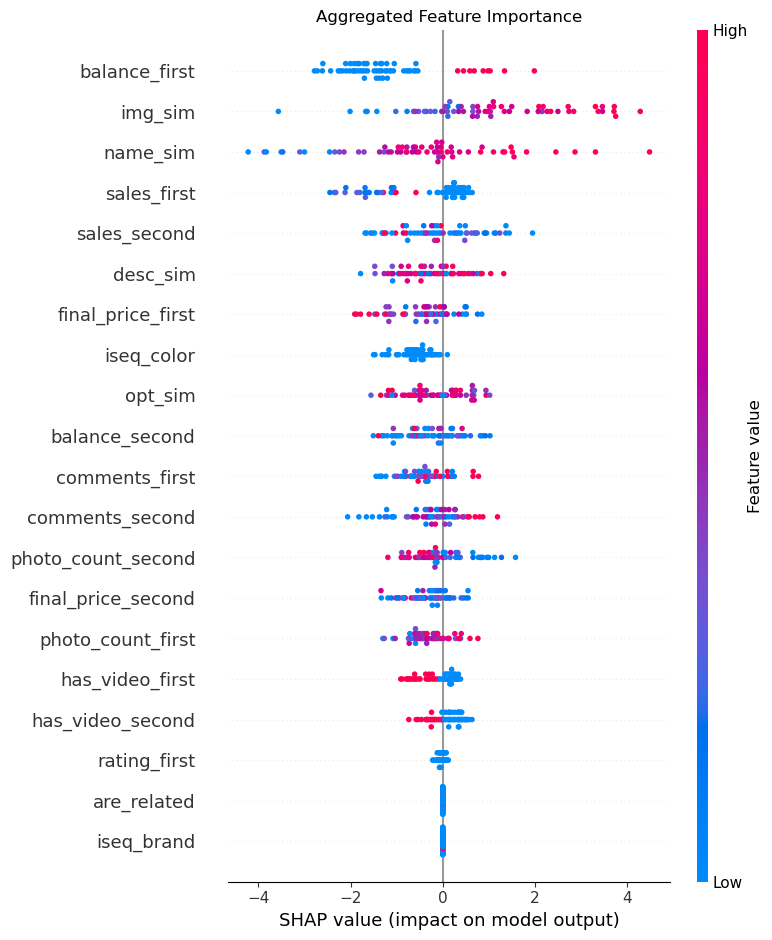

Query #0 ########################################
Query SKU: 64354727
Query Name: Карта мира настенная 157х107 см географическая большая
              Query SKU
sku         64354727.00
final_price      684.00
balance            0.00
sales              0.00
rating             5.00
comments          97.00
name_sim           0.87
img_sim            0.55
desc_sim           0.74
opt_sim            0.85
------------------------------------------------------------
Top-4 SKU: 64129693
Top-4 Name: Настенная карта мира физическая, интерактивная, 120х78 см

Match probability: 0.2154
Predicted label: 0
True label: 1

             Candidate SKU
sku            64129693.00
final_price         571.00
balance              62.00
sales                20.00
rating                5.00
comments            363.00
name_sim              0.87
img_sim               0.55
desc_sim              0.74
opt_sim               0.85


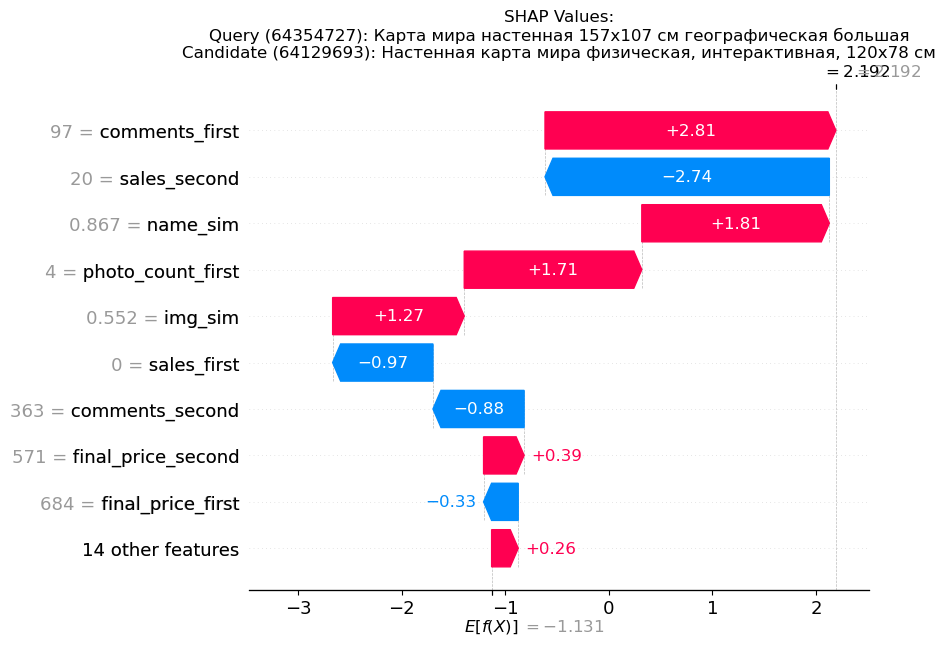



Query #1 ########################################
Query SKU: 64354832
Query Name: Карта России на стену физическая большая 157х107см
              Query SKU
sku         64354832.00
final_price      664.00
balance            0.00
sales              9.00
rating             5.00
comments         897.00
name_sim           0.73
img_sim            0.82
desc_sim           0.87
opt_sim            0.98
------------------------------------------------------------
Top-3 SKU: 64354945
Top-3 Name: Карта России политическая с флагами субъектов РФ 157х107 см

Match probability: 0.0009
Predicted label: 0
True label: 1

             Candidate SKU
sku            64354945.00
final_price         708.00
balance               0.00
sales                89.00
rating                5.00
comments            897.00
name_sim              0.73
img_sim               0.82
desc_sim              0.87
opt_sim               0.98


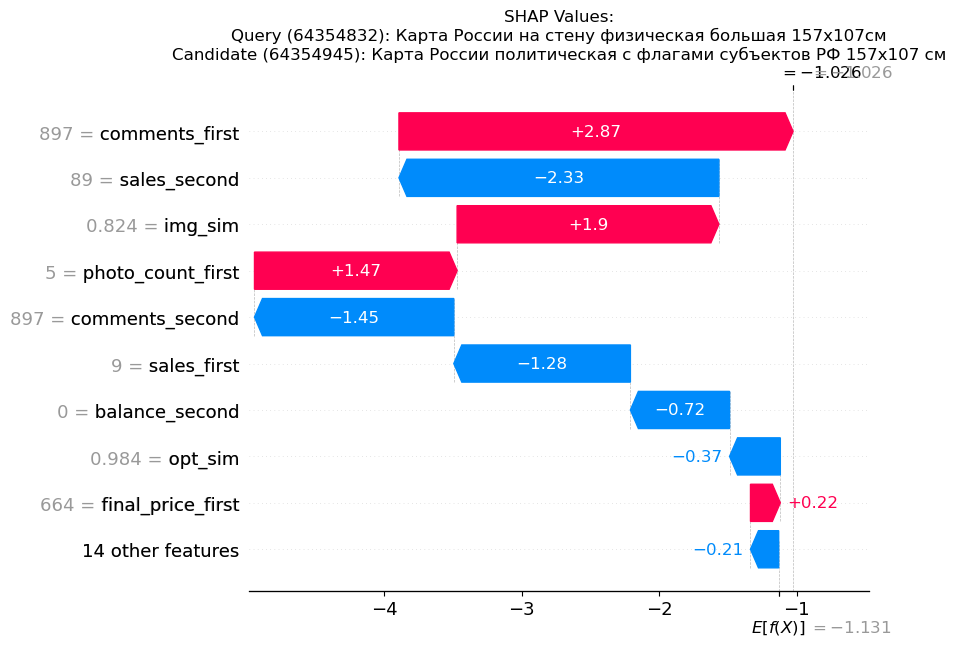



Query #2 ########################################
Query SKU: 178005436
Query Name: Большая карта мира настенная географическая 160х107 см
               Query SKU
sku         178005436.00
final_price      1178.00
balance             0.00
sales               0.00
rating              5.00
comments           27.00
name_sim            0.71
img_sim             0.68
desc_sim            0.88
opt_sim             0.93
------------------------------------------------------------
Top-3 SKU: 54671906
Top-3 Name: Карта мира настенная политическая, на стену для детей

Match probability: 0.0002
Predicted label: 0
True label: 1

             Candidate SKU
sku            54671906.00
final_price         988.00
balance               0.00
sales                 3.00
rating                5.00
comments           2075.00
name_sim              0.71
img_sim               0.68
desc_sim              0.88
opt_sim               0.93


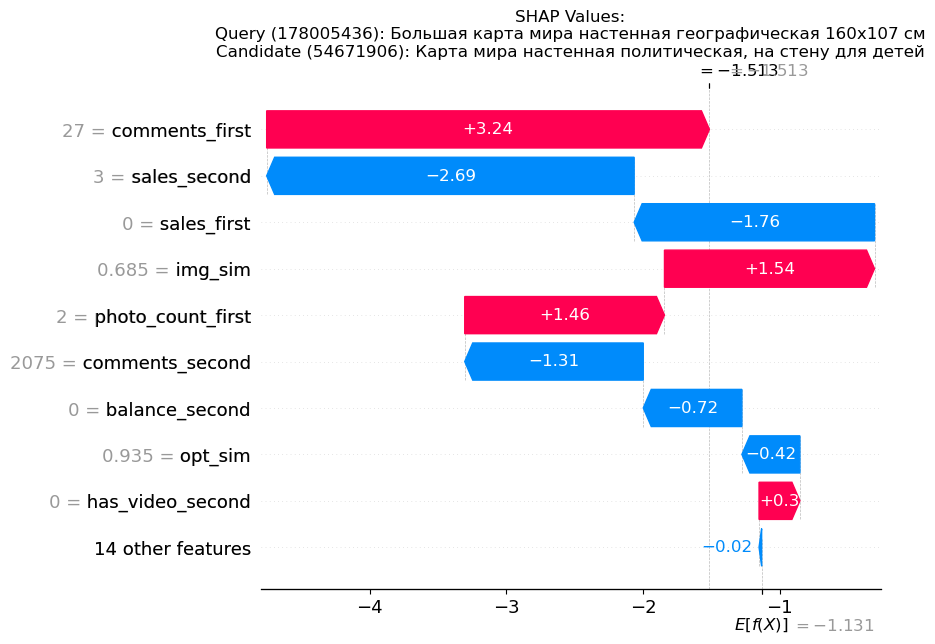

In [209]:
print_samples(
    results_df,

    # mode='predicted_matches_head',
    # mode='predicted_matches_tail',
    mode='hard_fn',
    # mode='easy_fn',
    # mode='hard_fp',
    # mode='easy_fp',
    # mode='true_matches_head',
    # mode='true_matches_tail',

    display_stats=True,
    stats_fmt='text', # or 'table'
    display_name=True,
    display_shap=True,  # Flag to control SHAP explanation display

    # agg_waterfall=False,  # Whether to show initial aggregated waterfall
    waterfalls=True,    # Whether to show individual waterfalls
    # shap_values=False    # Whether to print detailed top SHAP values report
)


Query and Candidate SKU fields:
------------------------------
              Query SKU  Candidate SKU
sku         64354727.00    64129693.00
final_price      684.00         571.00
balance            0.00          62.00
sales              0.00          20.00
rating             5.00           5.00
comments          97.00         363.00
name_sim           0.87           0.87
img_sim            0.55           0.55
desc_sim           0.74           0.74
opt_sim            0.85           0.85


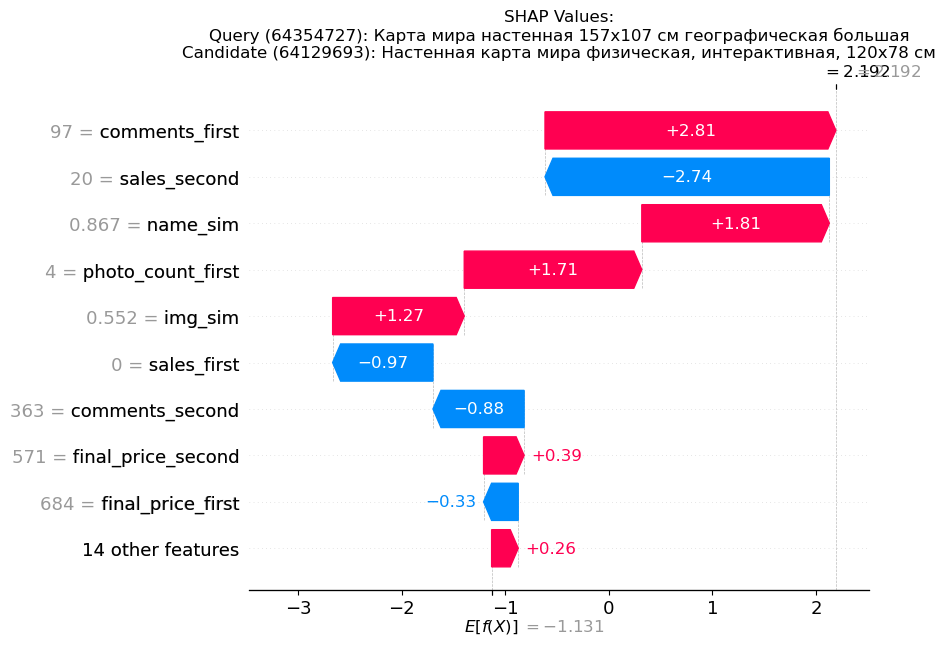


SHAP explanation for pair:
Query SKU: 64354727
Candidate SKU: 64129693


In [204]:
# compare two SKUs
query_sku_first = 64354727  # Replace with the actual SKU
candidate_sku_second = 64129693  # Replace with the actual SKU

# Print numerical fields for query and candidate SKUs
# Get the row for the SKU pair
row = results_df[(results_df['sku_first'] == query_sku_first) & 
                 (results_df['sku_second'] == candidate_sku_second)].iloc[0]

print("\nQuery and Candidate SKU fields:")
print("-" * 30)
# Create a dictionary with the fields to display
fields_dict = {
    'Query SKU': {
        'sku': query_sku_first,
        'final_price': row['final_price_first'],
        'balance': row['balance_first'],
        'sales': row['sales_first'], 
        'rating': row['rating_first'],
        'comments': row['comments_first'],
        'name_sim': row['name_sim'],
        'img_sim': row['img_sim'],
        'desc_sim': row['desc_sim'],
        'opt_sim': row['opt_sim']
    },
    'Candidate SKU': {
        'sku': candidate_sku_second,
        'final_price': row['final_price_second'], 
        'balance': row['balance_second'],
        'sales': row['sales_second'],
        'rating': row['rating_second'], 
        'comments': row['comments_second'],
        'name_sim': row['name_sim'],
        'img_sim': row['img_sim'],
        'desc_sim': row['desc_sim'],
        'opt_sim': row['opt_sim']
    }
}

# Convert to DataFrame and display
comparison_df = pd.DataFrame(fields_dict)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(comparison_df)

# Filter the results_df to get the row corresponding to the target pair of SKUs
target_row = results_df[(results_df['sku_first'] == query_sku_first) & 
                       (results_df['sku_second'] == candidate_sku_second)]

# Check if the target pair exists in the DataFrame
if not target_row.empty:
    # Get features for SHAP explanation
    features = target_row[model.feature_names]
    scaled_features = features.copy()
    
    # Get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values_row = explainer.shap_values(scaled_features)
    expected_value = explainer.expected_value

    # Print top contributing features
    top_features = pd.DataFrame({
        'Feature': features.columns,
        'SHAP Value': shap_values_row[0],
        'Feature Value': features.values[0],
        'Scaled Value': scaled_features.values[0]
    }).sort_values(by='SHAP Value', key=abs, ascending=False).head(5)

    expected_value_float = expected_value.item() if isinstance(expected_value, np.ndarray) else expected_value

    # Plot waterfall
    plt.figure(figsize=(10, 6))
    title = f"SHAP Values:\nQuery ({query_sku_first}): {row['name_first']}\nCandidate ({candidate_sku_second}): {row['name_second']}"
    plt.title(title, wrap=True)
    shap.plots.waterfall(shap.Explanation(
        values=shap_values_row[0],
        base_values=expected_value_float,
        data=scaled_features.values[0],
        feature_names=model.feature_names
    ), max_display=10, show=True)
    
    print(f"\nSHAP explanation for pair:")
    print(f"Query SKU: {query_sku_first}")
    print(f"Candidate SKU: {candidate_sku_second}")
else:
    print(f"No data found for SKU pair: {query_sku_first}, {candidate_sku_second}")


In [155]:
row[['options_first', 'options_second']]

options_first           Высота предмета: 107 см. Ширина предмета: 160 см. Тип карты: настенная; географическая; стирающаяся. Вид карты: политическая; Географическая; Настенная. Масштаб: 1:20 000 000. Автор: Атлас Принт. Редакция: атлас принт. Страна производства: Россия. Комплектация: Политическая карта мира 160х107 см - 1 шт. 
options_second    Высота предмета: 112 см. Ширина предмета: 180 см. Тип карты: настенная; Географическая; политическая карта. Вид карты: политическая; Настенная; Географическая. Масштаб: 1:18000000. Автор: Клавдий Птолемей. Редакция: РПГ Карандаш. Страна производства: Россия. Комплектация: Карта мира 186х117 см в тубусе - 1шт. 
Name: 268, dtype: object

# Output files

In [ ]:
def construct_wide_table(df, top_k):
    """
    Constructs a wide table such that each row corresponds to a unique query SKU and contains:
    
      Query_SKU, Top-1_SKU, Top-2_SKU, ... Top-k_SKU,
      Query_URL, Top-1_URL, Top-2_URL, ... Top-k_URL,
      Top-1_Proba, Top-2_Proba, ... Top-k_Proba
      
    Only candidates with a positive prediction (prediction == 1) are included.
    If there are fewer than top_k positive predictions for a query, the remaining columns are filled with None.
    """
    wide_rows = []
    # Process each unique query SKU.
    for query_sku, group in df.groupby('sku_first'):
        # Consider only candidates with positive prediction.
        group_positive = group[group['prediction'] == 1]
        # Sort the positive candidates by probability in descending order.
        group_sorted = group_positive.sort_values(by='proba', ascending=False).reset_index(drop=True)
        # Assume the query URL is the same for every row with the same query SKU.
        query_url = group_sorted.loc[0, 'url_first'] if not group_sorted.empty else None
        
        # Build the row dictionary with the desired column order.
        row = {}
        row['Query_SKU'] = query_sku
        
        # Add candidate SKU columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_SKU'] = group_sorted.loc[i, 'sku_second']
            else:
                row[f'Top-{i+1}_SKU'] = None
        
        # Add the Query URL.
        row['Query_URL'] = query_url
        
        # Add candidate URL columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_URL'] = group_sorted.loc[i, 'url_second']
            else:
                row[f'Top-{i+1}_URL'] = None
        
        # Add candidate probability columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_proba'] = group_sorted.loc[i, 'proba']
            else:
                row[f'Top-{i+1}_proba'] = None
        
        wide_rows.append(row)
    return pd.DataFrame(wide_rows)


In [ ]:
# # --- Set your desired top_k (e.g. 5) and construct the wide table.
# TOP_K = 5

# matches_wide_df = construct_wide_table(df_grouped_sorted, TOP_K)
# matches_wide_df = matches_wide_df.dropna()
# matches_wide_df

In [ ]:
# subset_cols = [
#     'Query_SKU',
#     # 'Top-1_SKU', 'Top-2_SKU', 'Top-3_SKU', 'Top-4_SKU', 'Top-5_SKU',
#     # 'Query_URL',
#     # 'Top-1_URL', 'Top-2_URL', 'Top-3_URL', 'Top-4_URL', 'Top-5_URL',
#     # 'Top-1_proba', 'Top-2_proba', 'Top-3_proba', 'Top-4_proba', 'Top-5_proba'
# ]

# output_file_path = (
#     Path(DATA_FILE).parent /
#     Path('test_results') / 
#     'result-errors-template.csv'
#     # (f'result-errors-template-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
# )
# matches_wide_df.to_clipboard(index=False, header=True, excel=True, columns=subset_cols)
# matches_wide_df.to_csv(output_file_path, index=False, header=True, columns=subset_cols)

In [ ]:
# DATA_PATH = 'data'

# output_file_path = (
#     Path(DATA_FILE).parent /
#     Path('test_results') / 
#     (f'result-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
# )
# output_file_path.parent.mkdir(parents=True, exist_ok=True)
# # output_file_path

# matches_wide_df.to_csv(output_file_path, index=None)